In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from PIL import Image
from itertools import product

We are going to build attention-only TF and the regular TF below, and train them on synthetic markov data.

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.emb_dim = config.emb_dim
        self.n_head = config.num_heads
        self.head_dim = self.emb_dim // self.n_head
        assert self.emb_dim % self.n_head == 0, "Embedding dimension must be divisible by the number of heads."
        self.query = nn.Linear(self.emb_dim, self.emb_dim)
        self.key = nn.Linear(self.emb_dim, self.emb_dim)
        self.value = nn.Linear(self.emb_dim, self.emb_dim)
        self.out = nn.Linear(self.emb_dim, self.emb_dim)
        self.mask = torch.tril(torch.ones(config.seq_len, config.seq_len)).unsqueeze(0).unsqueeze(1)
        self.mask = self.mask.to(config.device)
        self.get_attn = config.get_attn

    def forward(self, x): # (B,T,C)
        batch_size, seq_len, embed_dim = x.size()
        Q = self.query(x).view(batch_size, seq_len, self.n_head, self.head_dim).transpose(1,2) # (B,H,T,D)
        K = self.key(x).view(batch_size, seq_len, self.n_head, self.head_dim).transpose(1,2)
        V = self.value(x).view(batch_size, seq_len, self.n_head, self.head_dim).transpose(1,2)
        attn_score = Q @ K.transpose(-1,-2) / (self.head_dim ** 0.5)
        attn_score = attn_score.masked_fill(self.mask==0, -float("inf"))
        attn = F.softmax(attn_score, dim=-1) # (B,H,T,T)
        out = attn @ V # (B, H, T, D)
        out = out.transpose(1,2).contiguous().view(batch_size,seq_len,-1) # (B, T, C)
        out = self.out(out)
        return out, attn.detach().cpu() if self.get_attn else out
        
        

class TFBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.MHA = MultiHeadAttention(config)
        self.ln1 = nn.LayerNorm(config.emb_dim) if config.layer_norm else None
        self.mlp = None
        self.dropout = None
        self.get_attn = config.get_attn

        if config.mlp:
            self.mlp = nn.Sequential(
                nn.Linear(config.emb_dim, config.ff_dim),
                nn.ReLU(),
                nn.Linear(config.ff_dim, config.emb_dim)
            )
            self.ln2 = nn.LayerNorm(config.emb_dim)
            
        if config.dropout:
            self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        attn_map = None
        if self.get_attn:
            atten_out, attn_map = self.MHA(x)
        else:
            atten_out = self.MHA(x)
        x = x + self.dropout(atten_out) if self.dropout else x + atten_out
        if self.ln1 is not None:
            x = self.ln1(x)
        if self.mlp is not None:
            mlp_out = self.mlp(x)
            x = self.ln2(x + self.dropout(mlp_out))
        return x, attn_map
        
class Transformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed = nn.Embedding(config.vocab_size, config.emb_dim).to(config.device)
        self.positional_encoding = nn.Parameter(torch.zeros(1, config.seq_len, config.emb_dim)).to(config.device)
        self.layers = nn.ModuleList([TFBlock(config) for _ in range(config.num_layers)])
        self.output_layer = nn.Linear(config.emb_dim, config.vocab_size)
        if config.get_attn:
            self.atten_maps = torch.zeros((config.num_layers, config.num_heads, config.seq_len, config.seq_len))

    def forward(self, x):
        x = self.embed(x) + self.positional_encoding[:, :x.size(1), :]
        for i, layer in enumerate(self.layers):
            x, attn_map = layer(x)
            if config.get_attn:
                self.atten_maps[i] = attn_map.mean(dim=0)
            
        logits = self.output_layer(x)
        return logits, self.atten_maps if config.get_attn else logits

In [17]:
class Config:
    def __init__(
        self, emb_dim, num_heads, num_layers, seq_len, vocab_size, batch_size, test_size, eval_iter, device="cpu",
        num_epochs=20, learning_rate=1e-3, alpha=1, order=2, ff_dim=None, get_attn=50,
        mlp=False, layer_norm=True, mask=True, dropout=None,
    ):
        # Model
        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.num_layers = num_layers
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        self.dropout = dropout
        self.mask = mask
        self.mlp = mlp
        self.layer_norm = layer_norm

        # Training
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.eval_iter = eval_iter
        self.get_attn = get_attn
        self.device = device
        
        # Data
        self.order = order
        self.alpha = alpha
        self.test_size = test_size

In [19]:
class MarkovSampler:
    def __init__(self, config):
        self.seq_len = config.seq_len
        self.num_states = config.vocab_size
        self.trans = {}
        self.order = config.order
        self.states = list(product(range(self.vocab_size), repeat=self.order))
        self.batch_size = config.batch_size
        self.test_size = config.test_size
        dirichlet_dist = torch.distributions.Dirichlet(torch.ones(self.num_states)*config.alpha)
        for state in self.states:
            probs = dirichlet_dist.sample((1,)).squeeze(0)
            self.trans[state] = probs / torch.sum(probs)
    
        
    def generate(self, mode="train"):
        if mode == "train":
            num_samples = self.batch_size
        else:
            num_samples = self.test_size
        samples = torch.zeros((num_samples, self.seq_len))
            
        for _ in range(self.seq_len-self.order):
            state = torch.randint(high=self.num_states, size=(num_samples, self.order))  # Start from a random initial state
            samples[:,:self.order] = state.clone()
            prev_state = tuple(sequence[-self.order:])
            prob = self.trans[prev_state]
            # assert torch.sum(prob) == 1., f"probability vectors have to sum to 1, {torch.sum(prob)} is different from 1."
            nxt_state = torch.multinomial(prob, 1).item()
            sequence.append(nxt_state)

        return torch.tensor(samples, dtype=torch.long)

In [21]:
class ngramLearner:
    def __init__(self, vocab_size, order):
        self.order = order
        self.vocab_size = vocab_size
        if order > 0:
            self.counter = {ngram: torch.ones((vocab_size,)) for ngram in list(product(range(vocab_size), repeat=order))}
        else:
            self.counter = torch.ones((config.vocab_size,))

    def update(self, batch):
        if self.order > 0:
            for b in range(batch.size(0)):
                seq = batch[b]
                for i in range(seq.size(0)-self.order):
                    state, nxt_state = tuple(seq[i:i+self.order].tolist()), int(seq[i+self.order])
                    self.counter[state][nxt_state] += 1
        else:
            self.counter += torch.bincount(batch.flatten(), minlength=config.vocab_size)
                
    def predict(self, batch):
        if self.order > 0:
            probs = torch.zeros((batch.size(0), batch.size(1)-1, self.vocab_size))
            for b in range(batch.size(0)):
                seq = batch[b]
                for i in range(1,seq.size(0)):
                    if i < self.order:
                        probs[b][i-1] = torch.ones((self.vocab_size,)) / self.vocab_size
                    else:
                        state = tuple(seq[i-self.order:i].tolist())
                        probs[b][i-1] = self.counter[state] / self.counter[state].sum()
            return probs
        else:
            targets = batch[:,1:].reshape(-1)
            probs = self.counter / self.counter.sum()
            probs = probs.unsqueeze(0).repeat(targets.size(0), 1)
            return probs.reshape(batch.size(0), batch.size(1)-1, self.vocab_size)

    def loss(self, batch):
        probs = self.predict(batch)
        one_hot_labels = F.one_hot(batch[:,1:], num_classes=self.vocab_size).float()
        loss = -torch.sum(one_hot_labels * torch.log(probs)) / batch.size(0) / (batch.size(1)-1)
        return loss

In [23]:
config = Config(
        emb_dim=64,
        num_heads=1,
        num_layers=2,
        seq_len=20,
        vocab_size=5,
        batch_size=256,
        test_size=2048,
        num_epochs=6000,
        eval_iter=50,
        order=3,
    )
model = Transformer(config)
model = model.to(config.device)
sampler = MarkovSampler(config)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
train_losses = []
eval_losses = []
eval_steps = []
test_data = sampler.generate(mode="test")
test_y = test_data[:,1:].reshape(-1).to(config.device)
attn_maps, test_attn_maps = {}, {}

uniLearner = ngramLearner(config.vocab_size, 0)
uni_losses = []

biLearner = ngramLearner(config.vocab_size, 1)
bi_losses = []

triLearner = ngramLearner(config.vocab_size, 2)
tri_losses = []

fourLearner = ngramLearner(config.vocab_size, 3)
four_losses = []

In [24]:
config.device

'cpu'

In [27]:
for epoch in trange(config.num_epochs):
    model.train()
    batch = sampler.generate()
    optimizer.zero_grad()
    targets = batch[:,1:]
    if epoch % config.get_attn == 0:
        outputs, attn = model(batch.to(config.device))
        attn_maps[epoch] = attn.clone()
    else:
        outputs, _ = model(batch.to(config.device))
    outputs = outputs[:,:-1,:].reshape(-1, config.vocab_size)

    # uni_loss = uniLearner.loss(batch)
    # uni_losses.append(uni_loss)
    # uniLearner.update(batch)

    # bi_loss = biLearner.loss(batch)
    # bi_losses.append(bi_loss)
    # biLearner.update(batch)

    # tri_loss = triLearner.loss(batch)
    # tri_losses.append(tri_loss)
    # triLearner.update(batch)

    # four_loss = fourLearner.loss(batch)
    # four_losses.append(four_loss)
    # fourLearner.update(batch)
    
    targets = targets.reshape(-1)
    targets = targets.to(config.device)
    loss = criterion(outputs, targets)
        
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    if epoch % config.eval_iter == 0:
        with torch.no_grad():
            model.eval()
            outputs, test_attn_maps = model(test_data.to(config.device))
            outputs = outputs[:,:-1,:].reshape(-1, config.vocab_size)
            loss = criterion(outputs, test_y)
            eval_losses.append(loss.item())
            eval_steps.append(epoch)
            # print(f"Epoch: {epoch}, Evaluation loss: {loss.item()}")

100%|██████████| 6000/6000 [29:21<00:00,  3.41it/s]


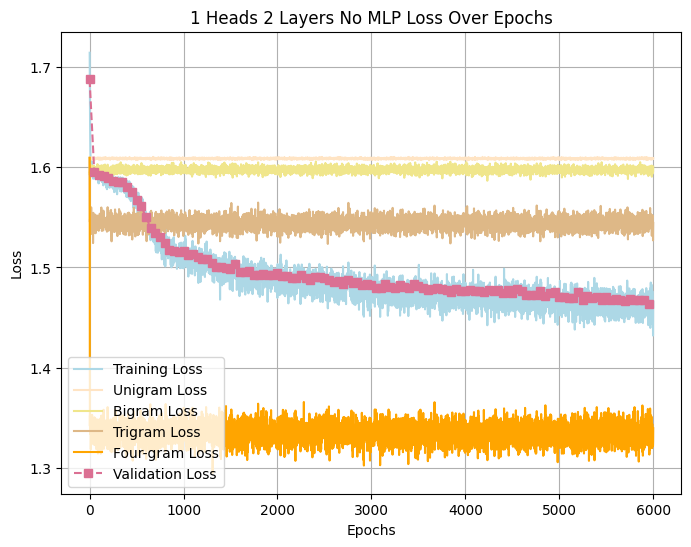

In [233]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, config.num_epochs + 1), train_losses, linestyle='-', color='lightblue', label='Training Loss')
plt.plot(range(1, config.num_epochs + 1), uni_losses, linestyle='-', color='bisque', label='Unigram Loss')
plt.plot(range(1, config.num_epochs + 1), bi_losses, linestyle='-', color='khaki', label='Bigram Loss')
plt.plot(range(1, config.num_epochs + 1), tri_losses, linestyle='-', color='burlywood', label='Trigram Loss')
plt.plot(range(1, config.num_epochs + 1), four_losses, linestyle='-', color='orange', label='Four-gram Loss')
plt.plot(eval_steps, eval_losses, marker='s', linestyle='--', color='palevioletred', label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('1 Heads 2 Layers No MLP Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

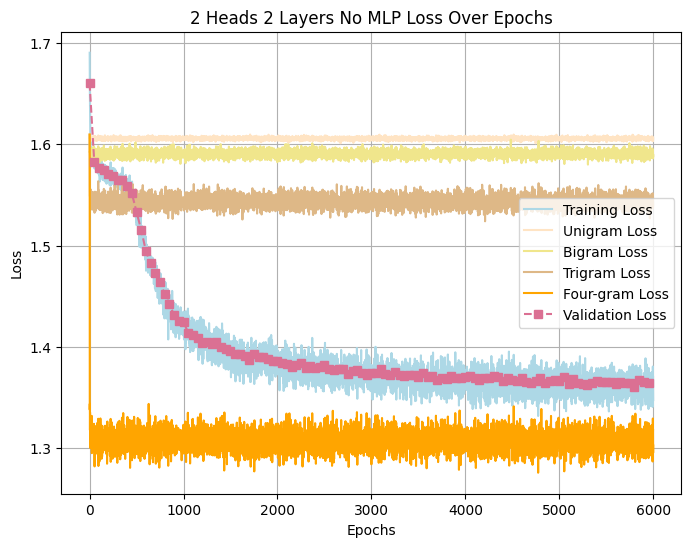

In [225]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, config.num_epochs + 1), train_losses, linestyle='-', color='lightblue', label='Training Loss')
plt.plot(range(1, config.num_epochs + 1), uni_losses, linestyle='-', color='bisque', label='Unigram Loss')
plt.plot(range(1, config.num_epochs + 1), bi_losses, linestyle='-', color='khaki', label='Bigram Loss')
plt.plot(range(1, config.num_epochs + 1), tri_losses, linestyle='-', color='burlywood', label='Trigram Loss')
plt.plot(range(1, config.num_epochs + 1), four_losses, linestyle='-', color='orange', label='Four-gram Loss')
plt.plot(eval_steps, eval_losses, marker='s', linestyle='--', color='palevioletred', label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('2 Heads 2 Layers No MLP Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

In [235]:
image_paths = []
layer = 1
head = 0
folder = "attns"
for i, attn in attn_maps.items():
    # Create heatmap
    plt.figure(figsize=(6, 5))
    plt.imshow(attn[layer][head], cmap="viridis", interpolation="nearest")
    plt.colorbar()
    plt.title(f"Epoch {i + 1}")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")

    # Save image
    image_path = f"{folder}/attn_l{config.num_layers}h{config.num_heads}o{config.order}v{config.vocab_size}ep{i}_L{layer}H{head}.png"
    plt.savefig(image_path)
    plt.close()
    image_paths.append(image_path)

# Step 2: Combine images into a GIF
frames = [Image.open(image_path) for image_path in image_paths]
output_gif_path = f"attnmaps_l{config.num_layers}h{config.num_heads}o{config.order}v{config.vocab_size}_L{layer}H{head}.gif"

frames[0].save(
    output_gif_path,
    save_all=True,
    append_images=frames[1:],
    duration=500,  # Duration between frames in milliseconds
    loop=0  # Infinite loop
)

print(f"GIF saved at {output_gif_path}")

GIF saved at attnmaps_l2h1o3v5_L1H0.gif
